#

## Covid19CXR Comprehensive Tutorial

This tutorial takes you from start to finish with the COVID19CXR dataset and explores many post-hoc deployment aspects of PyHealth

Namely, we go through:
- Loading the data
- Training a model
- Doing Conformal Prediction
- Running Interpretability on Predicted Samples

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from pyhealth.calib.predictionset import LABEL
from pyhealth.datasets import (
    COVID19CXRDataset,
    get_dataloader,
    split_by_sample_conformal,
)
from pyhealth.models import TorchvisionModel
from pyhealth.trainer import Trainer, get_metrics_fn
from pyhealth.interpret.methods import CheferRelevance
from pyhealth.interpret.utils import visualize_image_attr

torch.manual_seed(42)
np.random.seed(42)

/home/johnwu3/projects/PyHealth_Branch_Testing/PyHealth/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


This is a warning of potentially slow compute. You could uncomment this line and use the Python implementation instead of Cython.


In [ ]:
root = "/home/johnwu3/projects/PyHealth_Branch_Testing/datasets/COVID-19_Radiography_Dataset"
base_cache = "/home/johnwu3/projects/covid19cxr_base_cache"
task_cache = "/home/johnwu3/projects/covid19cxr_task_cache"
model_checkpoint = "/home/johnwu3/projects/covid19cxr_vit_model.ckpt"

base_dataset = COVID19CXRDataset(root, cache_dir=base_cache, num_workers=4)
sample_dataset = base_dataset.set_task(cache_dir=task_cache, num_workers=4)

print(f"Total samples: {len(sample_dataset)}")
print(f"Task mode: {sample_dataset.output_schema}")

# Get class names from dataset processor's label_vocab
# label_vocab maps {label_name: index}, we invert it to get {index: label_name}
label_vocab = sample_dataset.output_processors["disease"].label_vocab
id2label = {idx: label for label, idx in label_vocab.items()}
print(f"Classes: {list(id2label.values())}")

# Split into train/val/cal/test
train_data, val_data, cal_data, test_data = split_by_sample_conformal(
    dataset=sample_dataset, ratios=[0.6, 0.1, 0.15, 0.15]
)

print(f"Train: {len(train_data)}")
print(f"Val: {len(val_data)}")
print(f"Cal: {len(cal_data)} (for conformal calibration)")
print(f"Test: {len(test_data)}")

# Create data loaders (batch_size=64 for better GPU utilization)
train_loader = get_dataloader(train_data, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_data, batch_size=64, shuffle=False)
cal_loader = get_dataloader(cal_data, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_data, batch_size=64, shuffle=False)


No config path provided, using default config
Initializing covid19_cxr dataset from /home/johnwu3/projects/PyHealth_Branch_Testing/datasets/COVID-19_Radiography_Dataset (dev mode: False)
Setting task COVID19CXRClassification for covid19_cxr base dataset...
Fitting processors on the dataset...
Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
Processing samples and saving to /home/johnwu3/projects/covid19cxr_task_cache/samples_38b176c9-d393-4251-99cc-7de0b0557c39.ld...
Applying processors on data with 4 workers...
Detected Jupyter notebook environment, setting num_workers to 1
Single worker mode, processing sequentially
Worker 0 started processing 21165 samples. (0 to 21165)


  0%|          | 0/21165 [00:00<?, ?it/s]

Rank 0 inferred the following `['tensor', 'tensor']` data format.


100%|██████████| 21165/21165 [02:45<00:00, 127.89it/s]

Worker 0 finished processing samples.
Cached processed samples to /home/johnwu3/projects/covid19cxr_task_cache/samples_38b176c9-d393-4251-99cc-7de0b0557c39.ld


Total samples: 21165
Task mode: {'disease': 'multiclass'}
Classes: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
Train: 12699
Val: 2116
Cal: 3175 (for conformal calibration)
Test: 3175


### Dataloading/Dataset

In [3]:
print(f"Total samples: {len(sample_dataset)}")
print(f"Task mode: {sample_dataset.output_schema}")

# Get class names from dataset processor's label_vocab
# label_vocab maps {label_name: index}, we invert it to get {index: label_name}
label_vocab = sample_dataset.output_processors["disease"].label_vocab
id2label = {idx: label for label, idx in label_vocab.items()}
print(f"Classes: {list(id2label.values())}")

# Split into train/val/cal/test
train_data, val_data, cal_data, test_data = split_by_sample_conformal(
    dataset=sample_dataset, ratios=[0.6, 0.1, 0.15, 0.15]
)

print(f"Train: {len(train_data)}")
print(f"Val: {len(val_data)}")
print(f"Cal: {len(cal_data)} (for conformal calibration)")
print(f"Test: {len(test_data)}")

# Create data loaders (batch_size=64 for better GPU utilization)
train_loader = get_dataloader(train_data, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_data, batch_size=64, shuffle=False)
cal_loader = get_dataloader(cal_data, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_data, batch_size=64, shuffle=False)

Total samples: 21165
Task mode: {'disease': 'multiclass'}
Classes: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
Train: 12699
Val: 2116
Cal: 3175 (for conformal calibration)
Test: 3175


## Model Initialization

In [9]:
print("\n" + "=" * 80)
print("STEP 2: Vision Transformer (ViT) Model")
print("=" * 80)
# Initialize ViT with pretrained weights
model = TorchvisionModel(
    dataset=sample_dataset,
    model_name="vit_b_16",  # Vision Transformer Base with patch size 16
    model_config={"weights": "DEFAULT"},
)

device = "cuda:1" if torch.cuda.is_available() else "cpu"

# Check if saved model exists
if os.path.exists(model_checkpoint):
    print(f"Found saved model at {model_checkpoint}")
    print("Loading model from checkpoint...")
    trainer = Trainer(model=model, device=device, checkpoint_path=model_checkpoint)
    print("✓ Model loaded from checkpoint")
else:
    print(f"No saved model found at {model_checkpoint}")
    print("Training new model...")
    trainer = Trainer(model=model, device=device)

    print(f"Training on device: {device}")
    trainer.train(
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        epochs=50,
        monitor="accuracy",
    )

    # Save the trained model
    print(f"Saving model to {model_checkpoint}...")
    trainer.save_ckpt(model_checkpoint)
    print("✓ Model training completed and saved")

# Evaluate base model on test set
print("\nBase model performance on test set:")
y_true_base, y_prob_base, loss_base = trainer.inference(test_loader)
base_metrics = get_metrics_fn("multiclass")(
    y_true_base, y_prob_base, metrics=["accuracy", "f1_weighted"]
)
for metric, value in base_metrics.items():
    print(f"  {metric}: {value:.4f}")


STEP 2: Vision Transformer (ViT) Model
Found saved model at /home/johnwu3/projects/covid19cxr_vit_model.ckpt
Loading model from checkpoint...
TorchvisionModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features

Evaluation: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]

  accuracy: 0.8180
  f1_weighted: 0.8171


## Conformal Prediction

In [5]:
# ============================================================================
# STEP 3: Conformal Prediction with LABEL
# ============================================================================
print("\n" + "=" * 80)
print("STEP 3: Conformal Prediction with LABEL")
print("=" * 80)

# Target miscoverage rate of 10% (90% coverage)
alpha = 0.1
print(f"Target miscoverage rate: {alpha} (90% coverage)")

# Create LABEL predictor
label_predictor = LABEL(model=model, alpha=alpha)

# Calibrate on calibration set
print("Calibrating LABEL predictor...")
label_predictor.calibrate(cal_dataset=cal_data)

# Evaluate on test set



STEP 3: Conformal Prediction with LABEL
Target miscoverage rate: 0.1 (90% coverage)
Calibrating LABEL predictor...


retrieving ['y_prob', 'y_true']: 100%|██████████| 100/100 [00:13<00:00,  7.58it/s]


In [6]:
print("Evaluating LABEL predictor on test set...")
device="cuda:1"
y_true_label, y_prob_label, _, extra_label = Trainer(device=device, model=label_predictor).inference(
    test_loader, additional_outputs=["y_predset"]
)

label_metrics = get_metrics_fn("multiclass")(
    y_true_label,
    y_prob_label,
    metrics=["accuracy", "miscoverage_ps"],
    y_predset=extra_label["y_predset"],
)

# Calculate coverage and prediction set size
predset = (
    torch.tensor(extra_label["y_predset"])
    if isinstance(extra_label["y_predset"], np.ndarray)
    else extra_label["y_predset"]
)
avg_set_size = predset.float().sum(dim=1).mean().item()

# Extract scalar values from metrics
miscoverage = label_metrics["miscoverage_ps"]
if isinstance(miscoverage, np.ndarray):
    miscoverage = float(
        miscoverage.item() if miscoverage.size == 1 else miscoverage.mean()
    )
else:
    miscoverage = float(miscoverage)

coverage = 1 - miscoverage

print("\n" + "-" * 60)
print("CONFORMAL PREDICTION RESULTS")
print("-" * 60)
print(f"  Target coverage:      {1-alpha:.0%}")
print(f"  Empirical coverage:   {coverage:.2%}")
print(f"  Empirical miscoverage:{miscoverage:.4f}")
print(f"  Average set size:     {avg_set_size:.2f}")
print(f"  Efficiency:           {1.0/avg_set_size:.4f}")
print("-" * 60)

# ============================================================================
# STEP 4: Example Predictions with Prediction Sets
# ============================================================================
print("\n" + "=" * 80)
print("STEP 4: Example Predictions with Prediction Sets")
print("=" * 80)

for i in range(min(5, len(y_true_label))):
    true_class = int(y_true_label[i])
    pred_class = int(y_prob_label[i].argmax())
    pred_set = torch.where(predset[i])[0].cpu().numpy()

    print(f"\nExample {i+1}:")
    print(f"  True: {id2label.get(true_class)}, Pred: {id2label.get(pred_class)}")
    print(f"  Prediction set: {[id2label.get(c) for c in pred_set]}")

Evaluating LABEL predictor on test set...
LABEL(
  (model): TorchvisionModel(
    (model): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (encoder): Encoder(
        (dropout): Dropout(p=0.0, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
              (4): Dropout(p=0.0

Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluation: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


------------------------------------------------------------
CONFORMAL PREDICTION RESULTS
------------------------------------------------------------
  Target coverage:      90%
  Empirical coverage:   87.86%
  Empirical miscoverage:0.1214
  Average set size:     1.48
  Efficiency:           0.6768
------------------------------------------------------------

STEP 4: Example Predictions with Prediction Sets

Example 1:
  True: COVID, Pred: COVID
  Prediction set: ['COVID']

Example 2:
  True: Normal, Pred: Normal
  Prediction set: ['Normal']

Example 3:
  True: Lung Opacity, Pred: Lung Opacity
  Prediction set: ['Lung Opacity']

Example 4:
  True: Normal, Pred: Normal
  Prediction set: ['Normal']

Example 5:
  True: Normal, Pred: Normal
  Prediction set: ['Lung Opacity', 'Normal']



STEP 5: Interpretability Visualization

Generating Chefer attention attribution for 3 samples...
✓ Saved to: covid19_cxr_interpretability.png


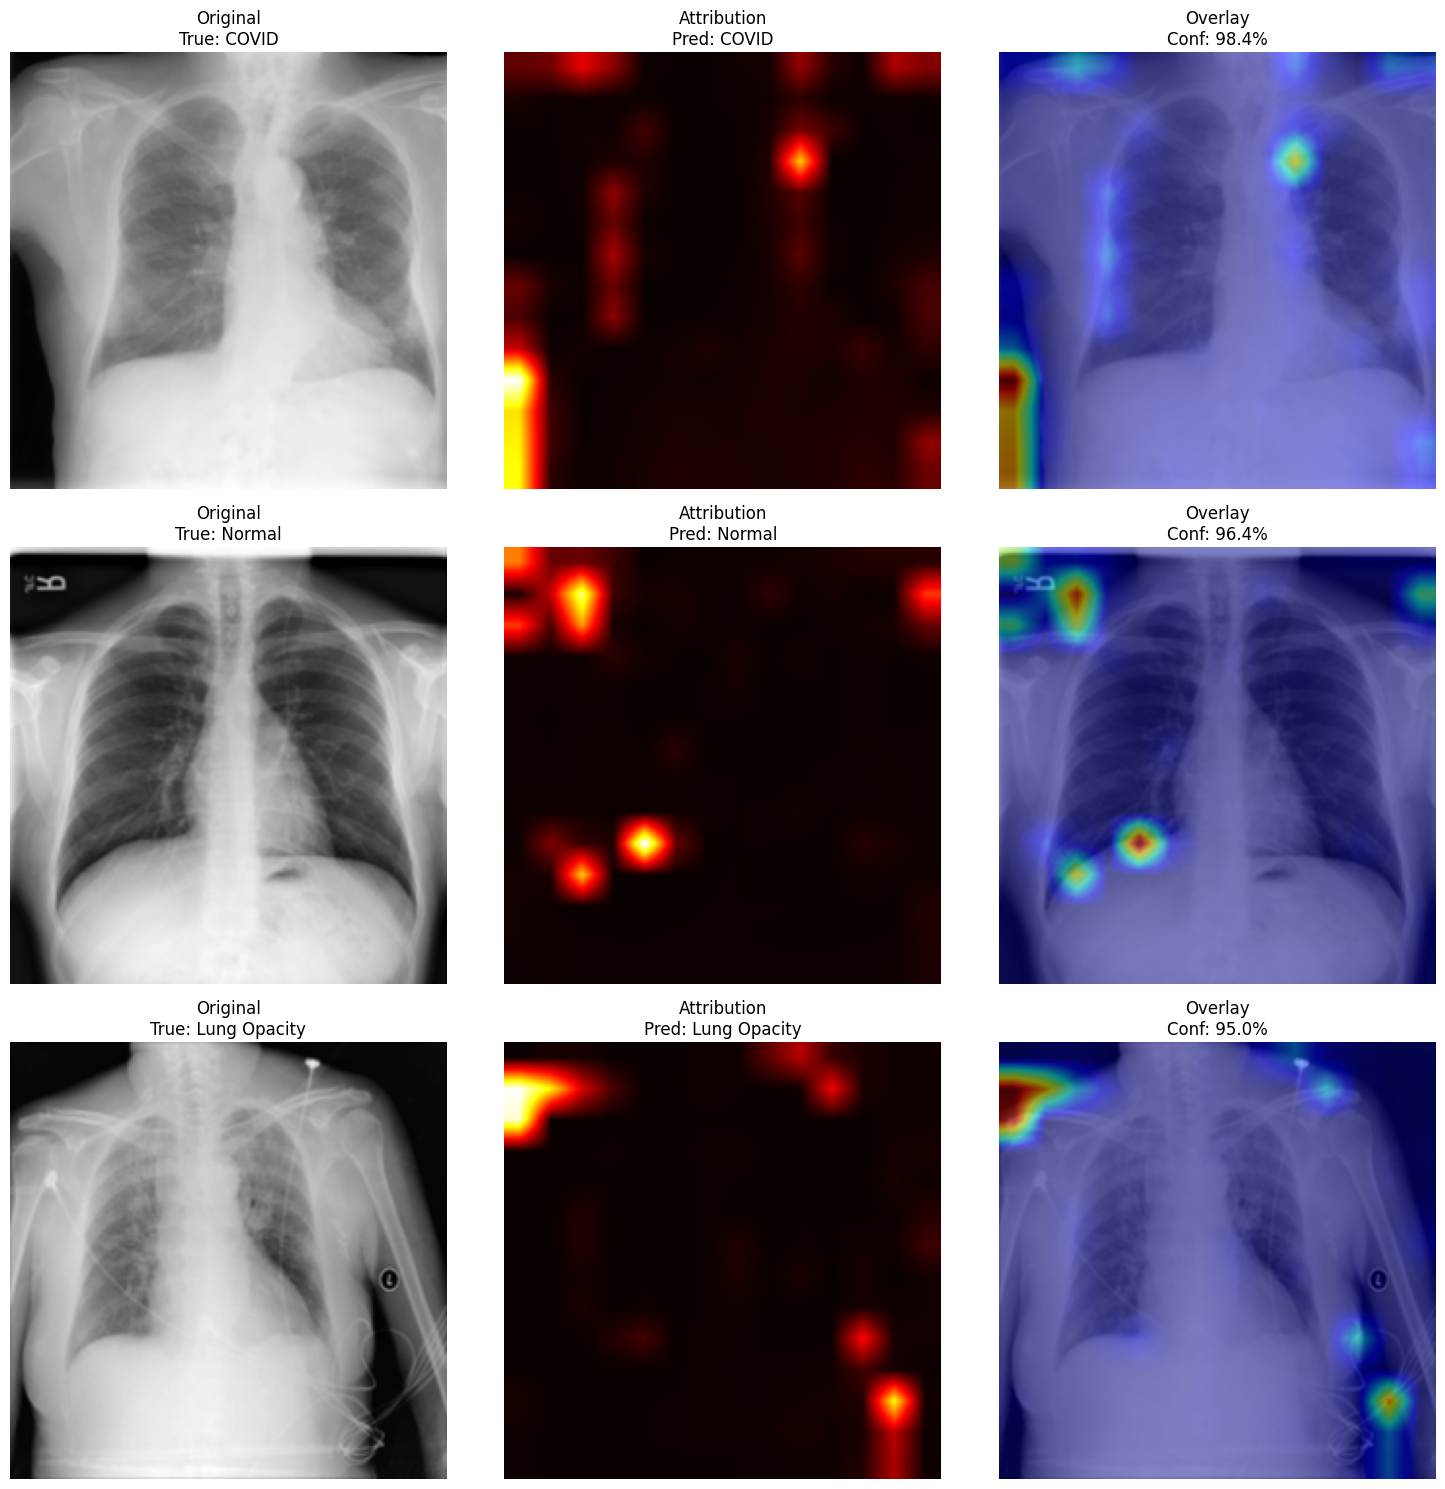

In [10]:
# ============================================================================
# STEP 5: Interpretability Visualization
# ============================================================================
print("\n" + "=" * 80)
print("STEP 5: Interpretability Visualization")
print("=" * 80)

single_loader = get_dataloader(test_data, batch_size=1, shuffle=False)
n_viz = 3
print(f"\nGenerating Chefer attention attribution for {n_viz} samples...")

model.eval()
viz_samples = [batch for i, batch in enumerate(single_loader) if i < n_viz]

fig, axes = plt.subplots(n_viz, 3, figsize=(15, 5 * n_viz))

# Initialize Chefer interpreter (auto-detects ViT)
chefer_gen = CheferRelevance(model)

for idx, batch in enumerate(viz_samples):
    image = batch["image"]
    true_label = batch["disease"].item()

    with torch.no_grad():
        output = model(**batch)
        pred_prob = output["y_prob"][0]
        pred_class = pred_prob.argmax().item()

    # Get attribution map using attribute()
    # Returns dict keyed by feature key (e.g., {"image": tensor})
    # Input size is inferred automatically from image dimensions
    result = chefer_gen.attribute(
        interpolate=True,
        class_index=pred_class,
        **batch
    )
    attr_map = result["image"]  # Keyed by task schema's feature key
    
    img_display, vit_attr_display, attention_overlay = visualize_image_attr(
        image=image[0],
        attribution=attr_map[0, 0],
        interpolate=True,
    )

    # Plot
    ax1 = axes[idx, 0]
    ax1.imshow(img_display, cmap='gray' if img_display.ndim == 2 else None)
    ax1.set_title(f"Original\nTrue: {id2label.get(true_label)}")
    ax1.axis('off')

    ax2 = axes[idx, 1]
    ax2.imshow(vit_attr_display, cmap='hot')
    ax2.set_title(f"Attribution\nPred: {id2label.get(pred_class)}")
    ax2.axis('off')

    ax3 = axes[idx, 2]
    ax3.imshow(attention_overlay)
    ax3.set_title(f"Overlay\nConf: {pred_prob[pred_class]:.1%}")
    ax3.axis('off')

plt.tight_layout()
plt.savefig("covid19_cxr_interpretability.png", dpi=150, bbox_inches='tight')
print("✓ Saved to: covid19_cxr_interpretability.png")